## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.3 (v0.3.3_dev:675e3c7, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 22.4 s, sys: 6min 13s, total: 6min 35s
Wall time: 31.9 s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with AMY1A region sequences 

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

AMY1A itself is small (~9kb). However, it resides in a region that have big repeats and the repeat configuration determines the copy numbers of AMY1A. In this analysis, we use 200k franking sequence on both ends to feteh the whole region.

68


(0.0, 409033.0)

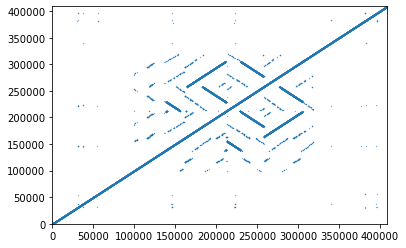

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr1_hg19', 104198140, 104207173
padding = 200000
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)

gene_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b, roi_e)

x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 125
The total aligned regions is 129


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG02080#1#JAHEOW010000048.1', 'HG02080.paternal.f1_assembly_v2_genbank.fa', 19194867) target region 16689583 - 17097287 len: 407704
('HG00621#2#JAHBCC010000031.1', 'HG00621.maternal.f1_assembly_v2_genbank.fa', 50348198) target region 16669999 - 17077865 len: 407866
('HG00621#1#JAHBCD010000034.1', 'HG00621.paternal.f1_assembly_v2_genbank.fa', 54097957) target region 2122997 - 2624098 len: 501101
('HG00733#1#JAHEPQ010000485.1', 'HG00733.paternal.f1_assembly_v2_genbank.fa', 282396) target region 246 - 281925 len: 281679
('HG01952#2#JAHAMD010000045.1', 'HG01952.maternal.f1_assembly_v2_genbank.fa', 21548543) target region 4381722 - 4883708 len: 501986
('NA21309#1#JAHEPC010000405.1', 'NA21309.paternal.f1_assembly_v2_genbank.fa', 49284) target region 258 - 47997 len: 47739
('HG01361#2#JAGYYW010000143.1', 'HG01361.maternal.f1_assembly_v2_genbank.fa', 119880) target region 674 - 119403 len: 118729
('HG01358#2#JAGYZA010000083.1', 'HG01358.maternal.f1_assembly_v2_genbank.fa', 51683152) target r

Text(0, 0.5, 'count')

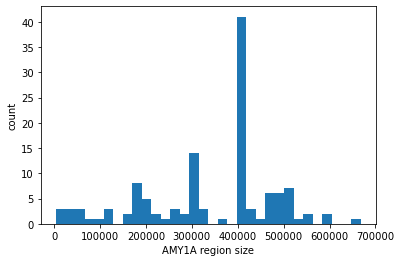

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("AMY1A region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the AMY1A by two vertical grey lines. We observe that there are different number of intersections (~different copy number of AMY1A) of the region the "dots" due to the different repeat structures.

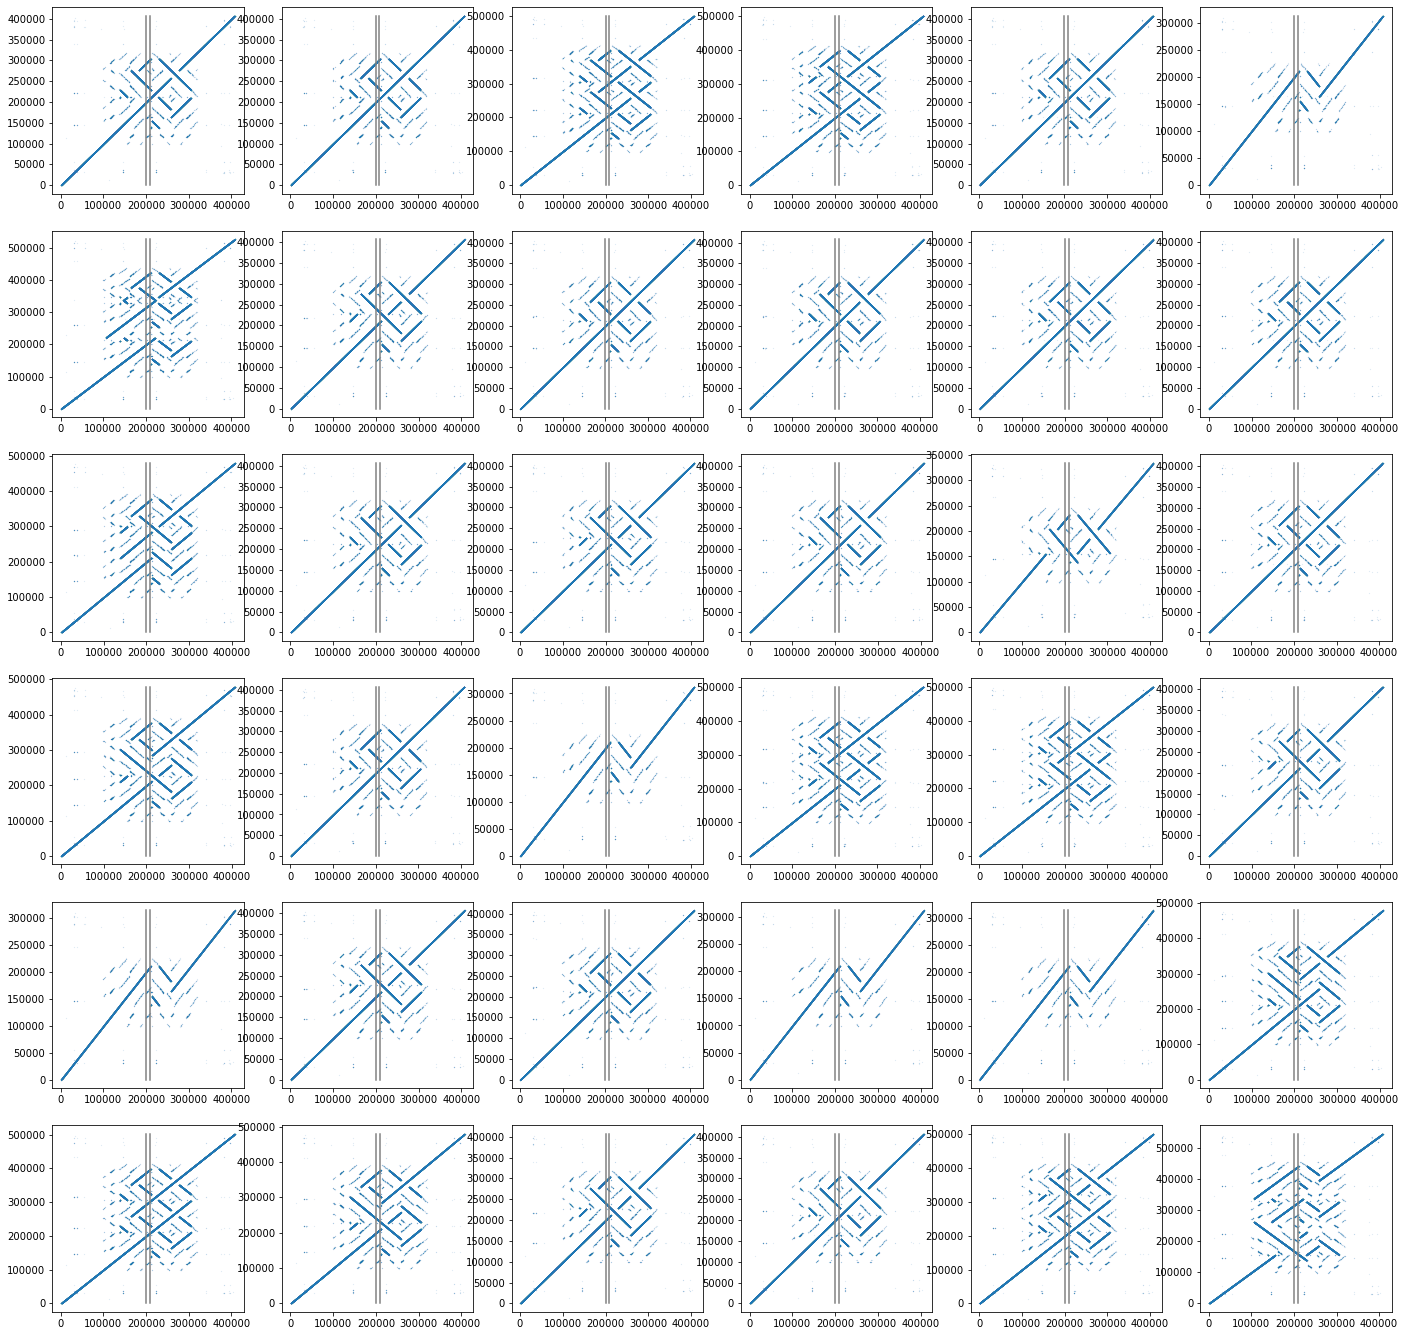

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
            continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 1, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

89

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 89
The total aligned regions is 90


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 88
number of copy: 2, number of haplotypes: 1


Text(0, 0.5, 'count')

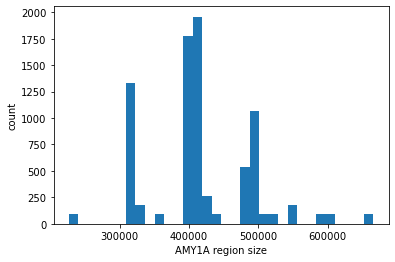

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("AMY1A region size")
plt.ylabel("count")

In [19]:
f0 = open("/results/AMY1A_region_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/AMY1A_region_80_56_6.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/AMY1A_region_80_56_2.gfa")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Graphviz layout (slow)

## Generate Repeat Pattern Using the Principal Bundles

In [25]:
shmmrspec = {"w": 48, "k":56, "r":4, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])


In [26]:
help(new_sdb.get_principal_bundle_decomposition)

Help on built-in function get_principal_bundle_decomposition:

get_principal_bundle_decomposition(...) method of builtins.SeqIndexDB instance
    Get the principal bundles and bundle decomposition of all seqeuences
    
    Parameters
    ----------
    min_count : int
        minimum coverage count to be included in the graph
    
    path_len_cut_off : int
        remove short path less than path_len_cut_off when generating the principal path
        
        if the number is small, the generated principal paths will be more fragemented.
     
    Returns
    -------
    tuple
        a tuple consist of two lists: (principal_bundles, seqid_smps_with_bundle_id_seg_direction)
     
        principal_bundles = list of (principal_bundle_id, ave_bundle_position, list_bundle_vertex)
       
        list_of_bundle_vertex = list of (hash0:u64, hash0:u64, direction:u8)
    
        seqid_smps_with_bundle_id_seg_direction = list of shimmer pairs in the database annotated with principal bundle 

In [27]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

28


In [28]:
import numpy as np
from matplotlib import cm

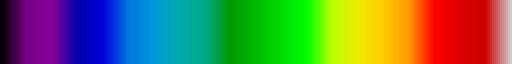

In [29]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [30]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0  3  6  9 12 15 18 21 24 27  2  5  8 11 14 17 20 23 26  1  4  7 10 13
 16 19 22 25]


In [31]:
gene_matches = new_sdb.get_match_positions_with_fragment(gene_seq)

In [33]:
from matplotlib.colors import to_hex as to_hex

In [34]:
new_sdb.generate_principal_mapg_gfa(0, 8, "/results/AMY1A_principal.gfa")

v_to_name = {}
v_to_bundle_id = {}
with open("/results/AMY1A_principal.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/AMY1A_principal_color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in principal_bundles:
    bundle_id = bundle[0]
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = to_hex(color_theme[bundle_id])
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, bundle_id, file=f, sep=",")
f.close()


new_sdb.generate_mapg_gfa(0, "/results/AMY1A.gfa")

v_to_name = {}
v_to_bundle_id = {}
with open("/results/AMY1A.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/AMY1A_color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in principal_bundles:
    bundle_id = bundle[0]
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = to_hex(color_theme[bundle_id])
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, bundle_id, file=f, sep=",")
f.close()

In [35]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

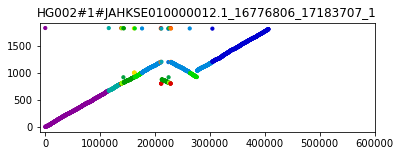

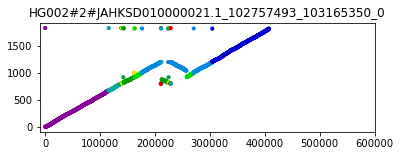

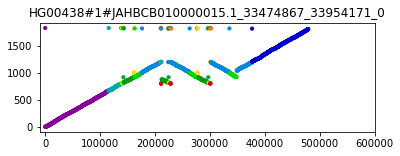

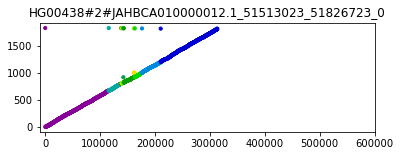

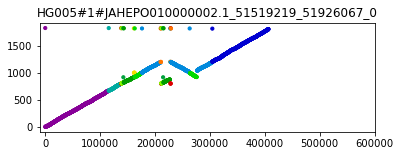

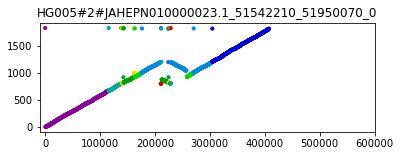

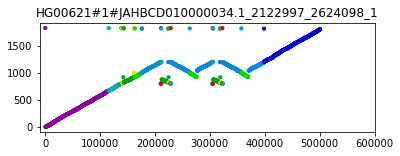

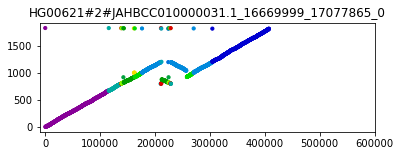

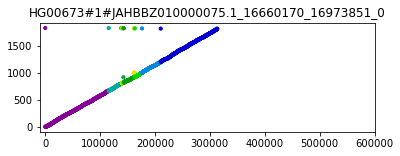

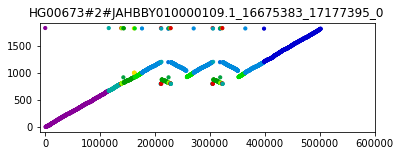

In [36]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,600000)
    plt.title(ctg)
    

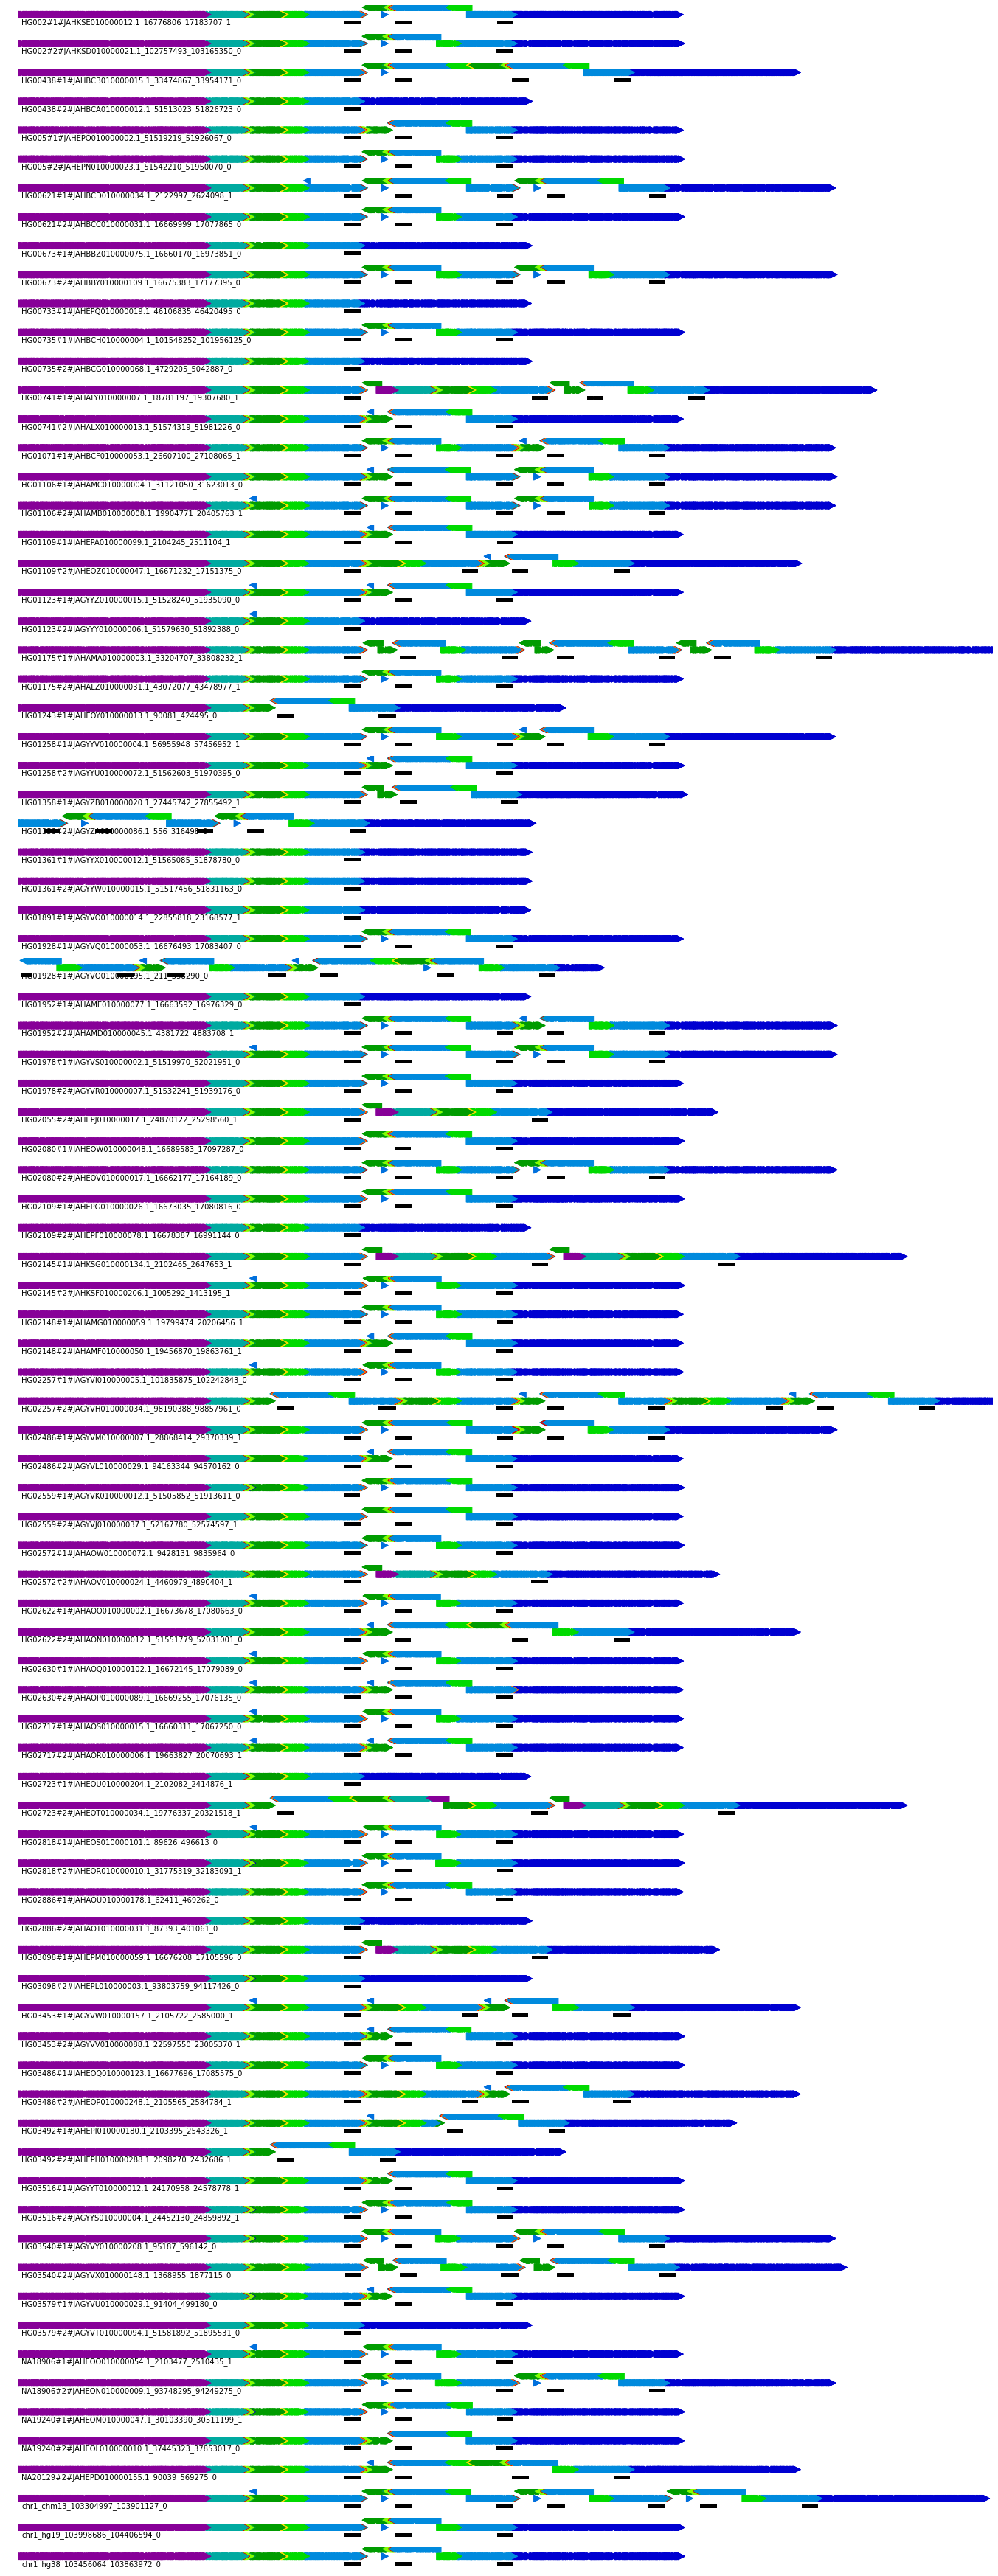

In [37]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
    matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    #plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color=track0_c, s=20)
    
    track0_x = [_[0] for _ in gene_matches[sid]]
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,600000)
    plt.text(0, -8, ctg)

/tmp/ipykernel_2794/3154699274.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,2))


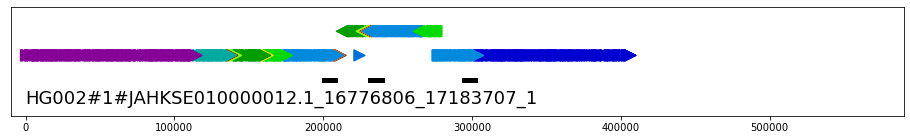

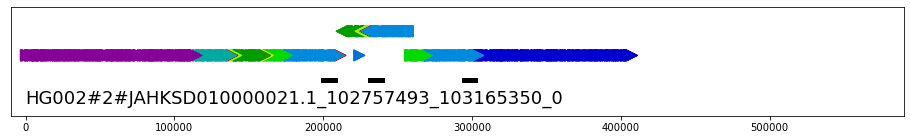

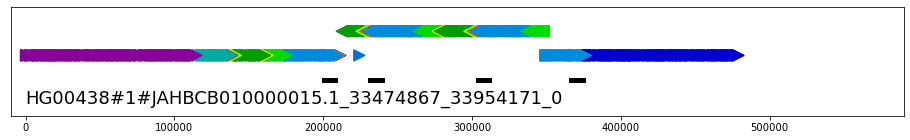

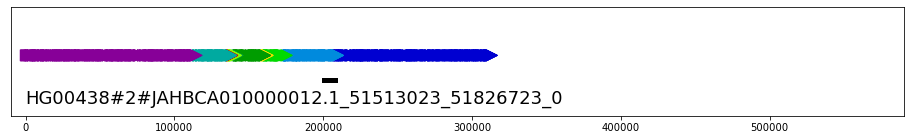

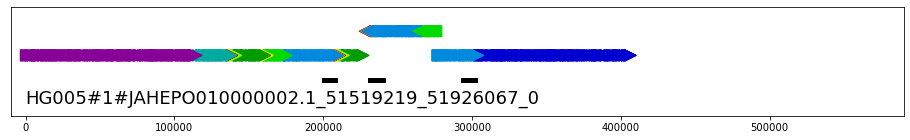

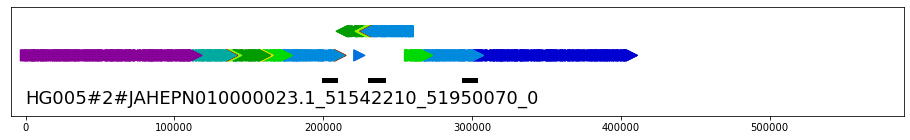

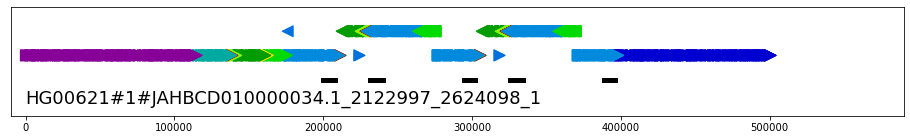

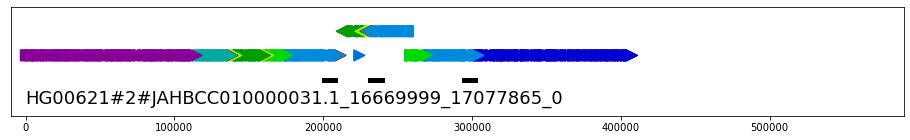

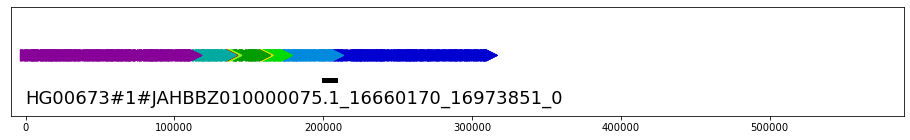

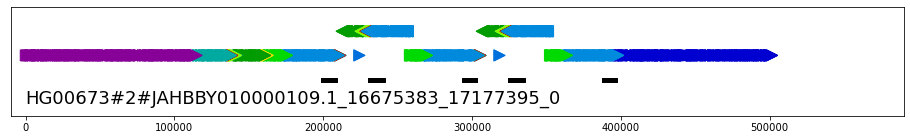

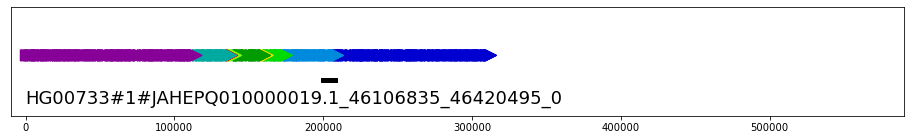

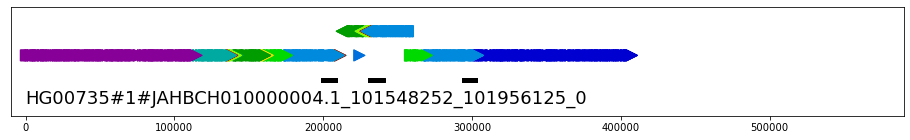

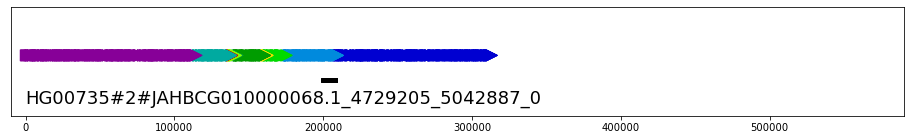

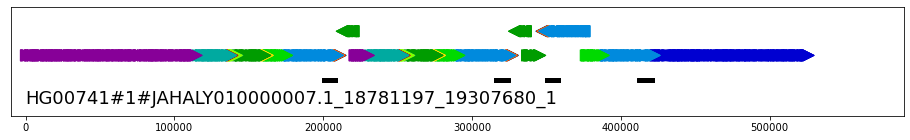

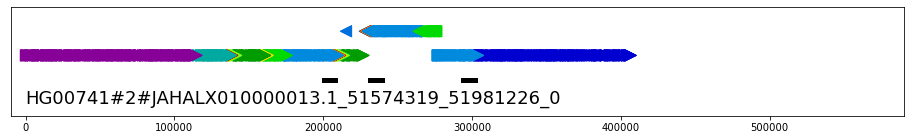

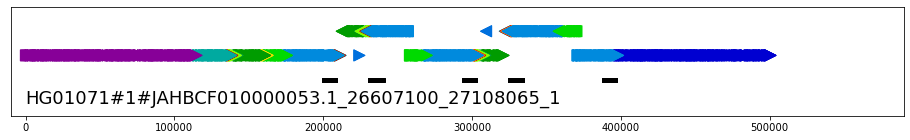

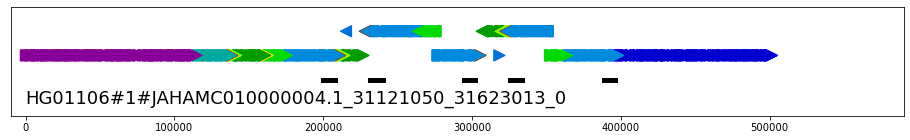

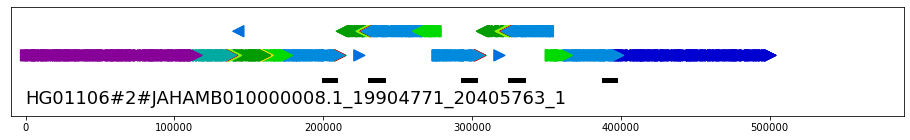

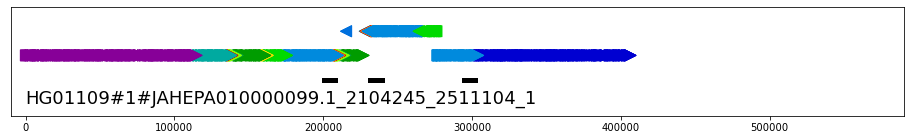

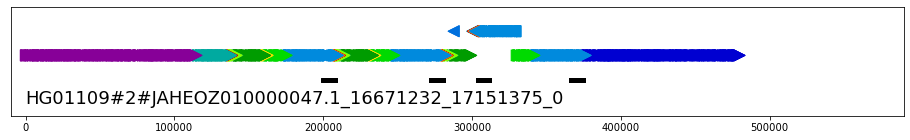

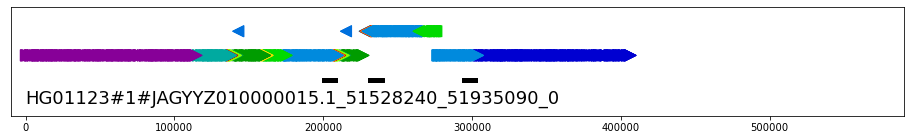

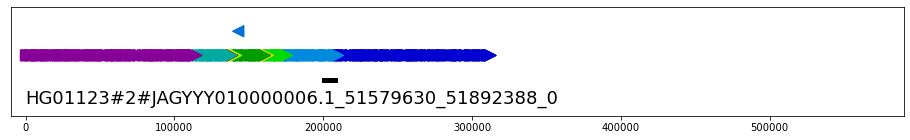

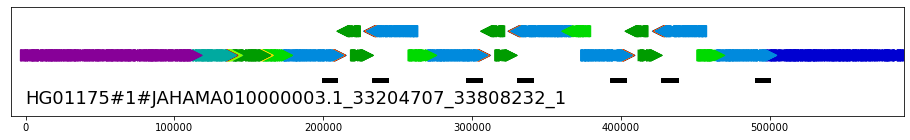

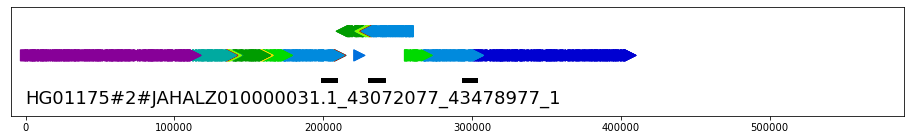

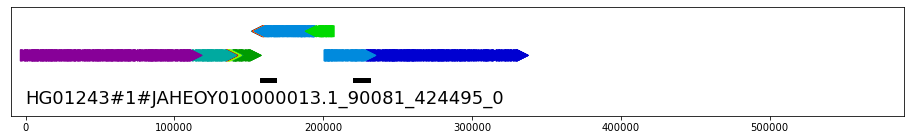

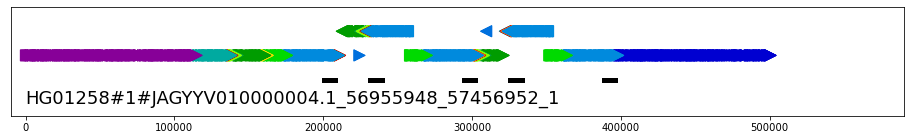

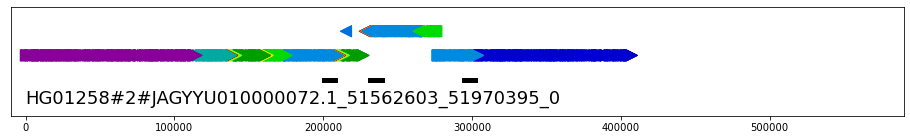

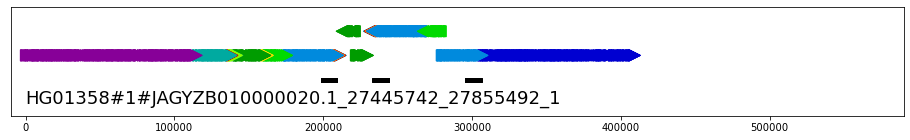

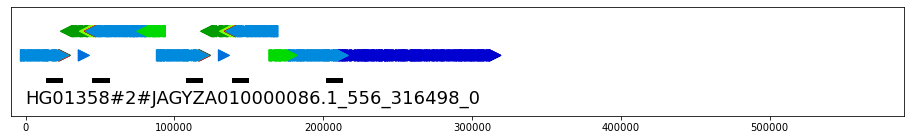

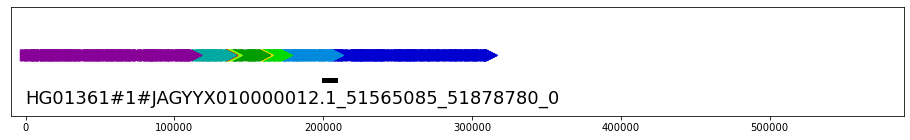

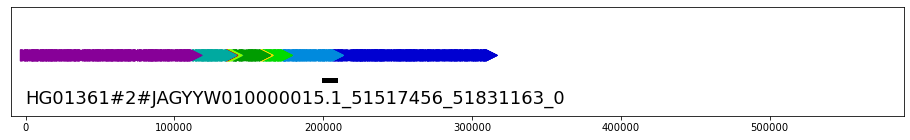

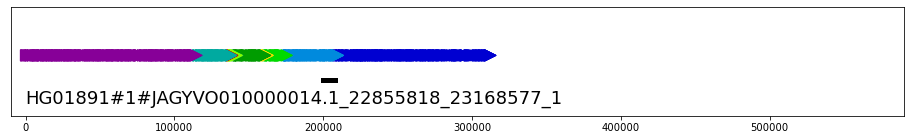

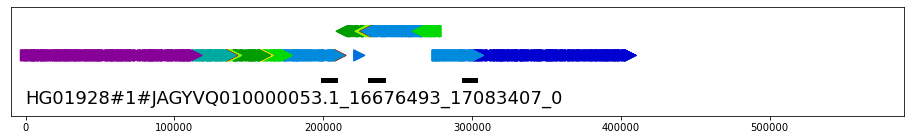

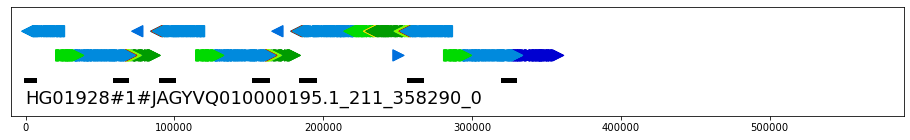

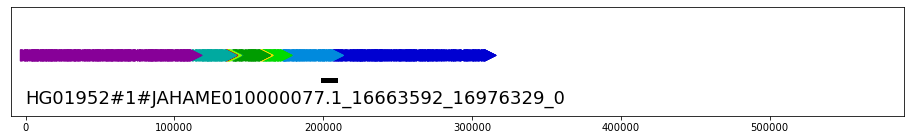

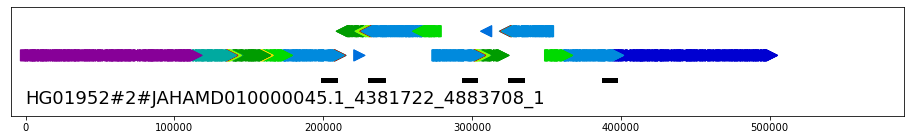

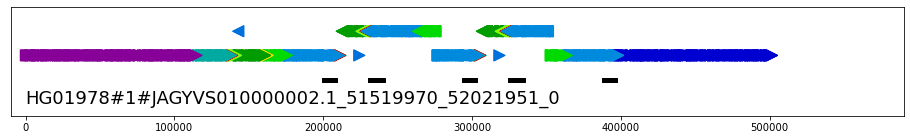

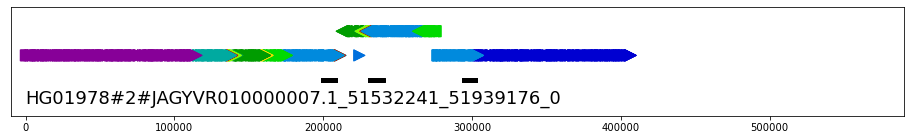

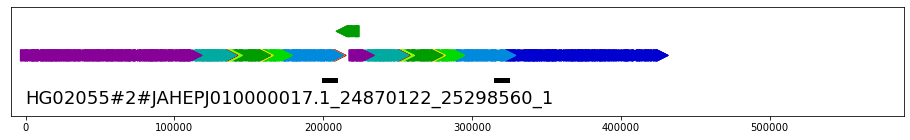

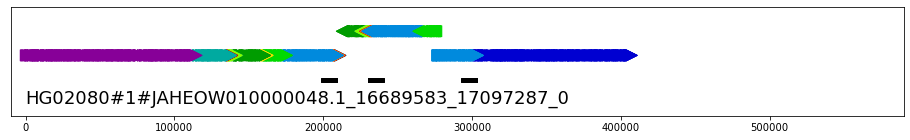

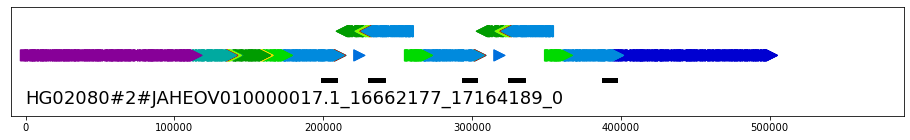

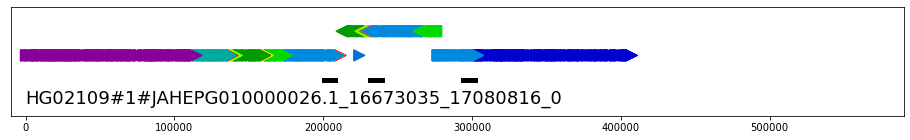

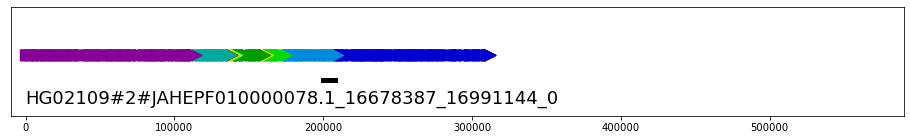

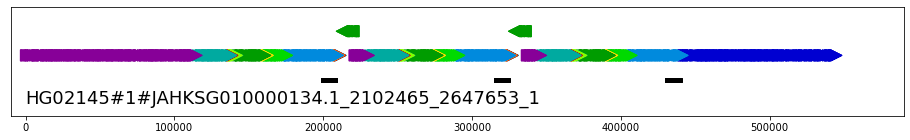

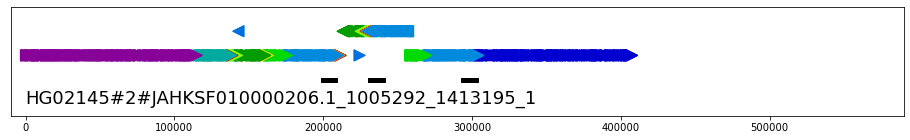

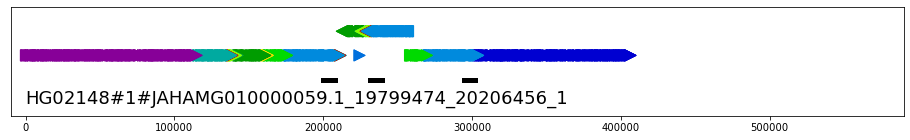

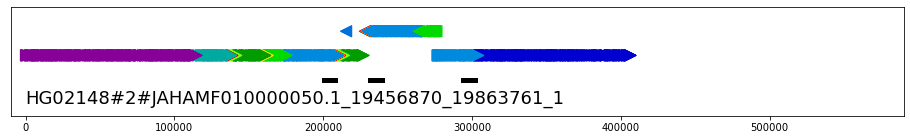

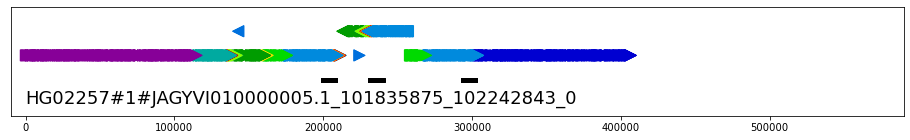

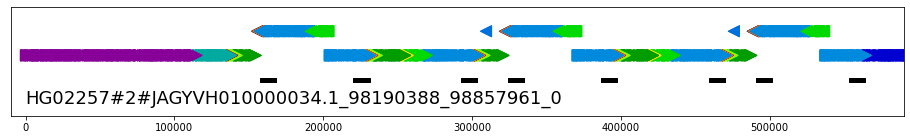

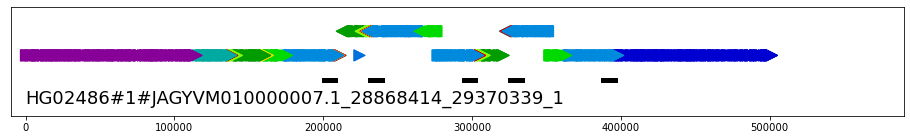

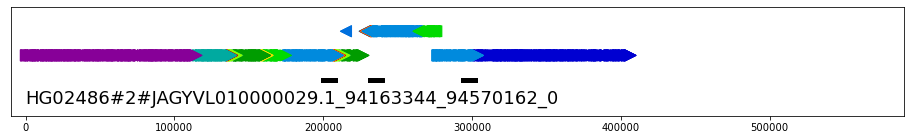

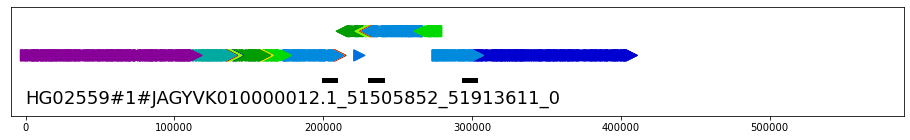

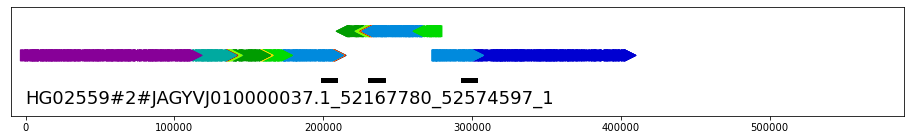

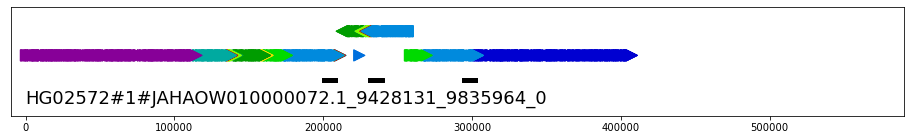

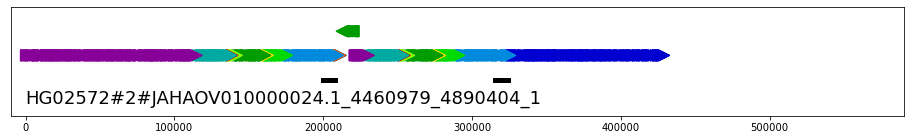

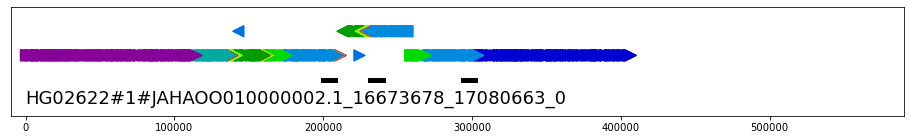

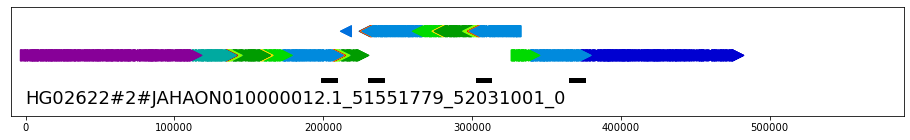

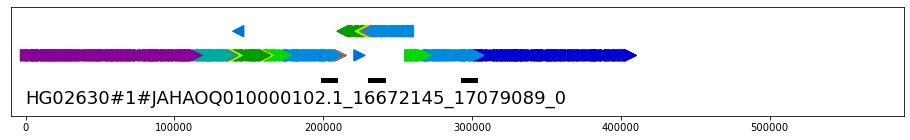

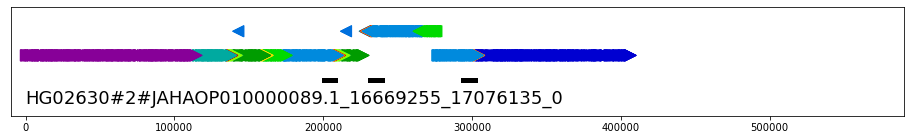

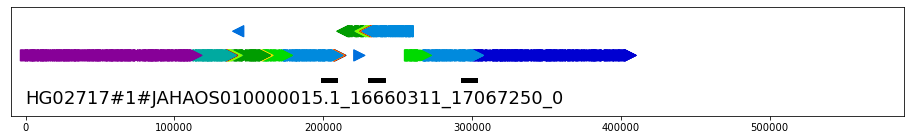

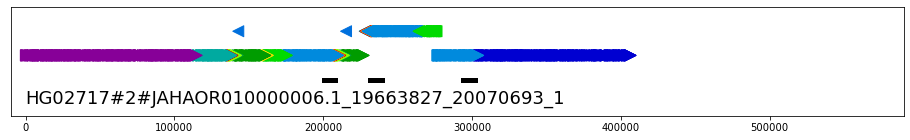

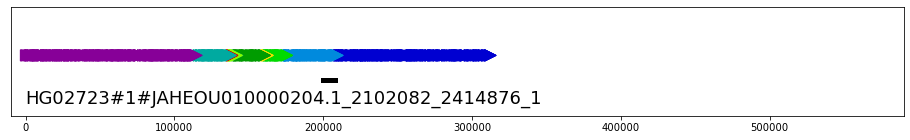

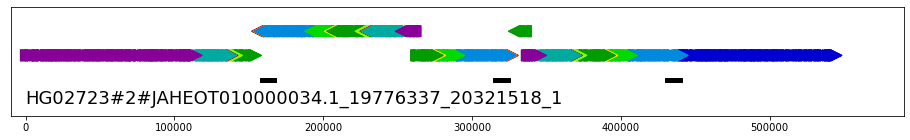

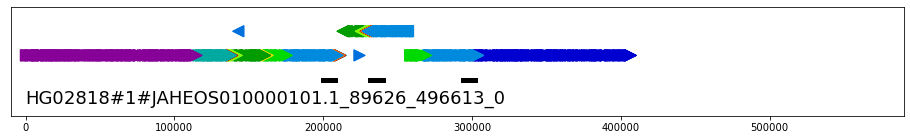

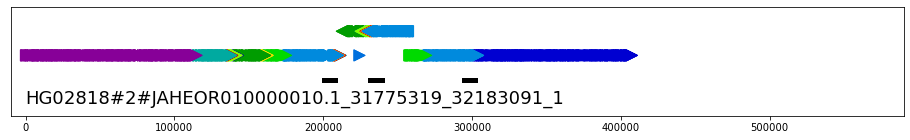

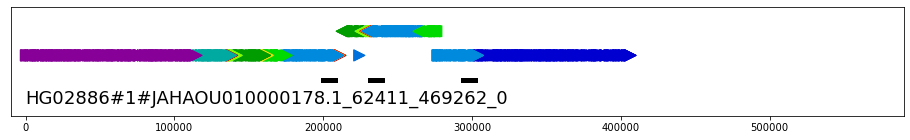

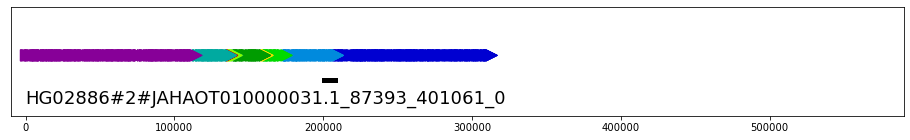

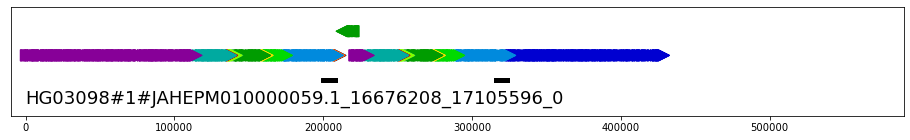

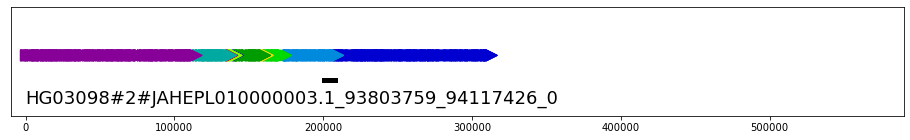

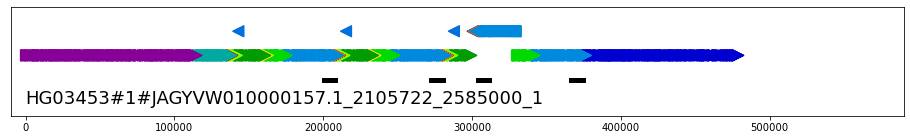

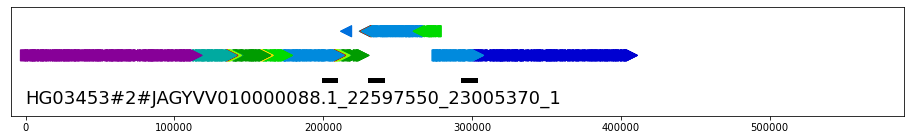

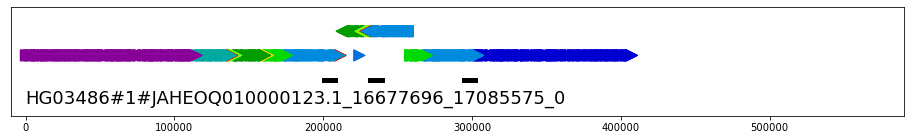

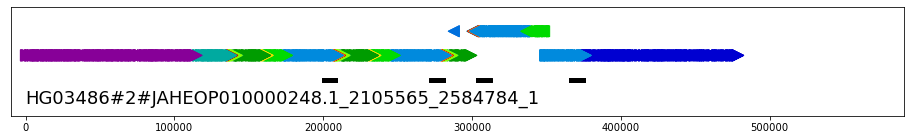

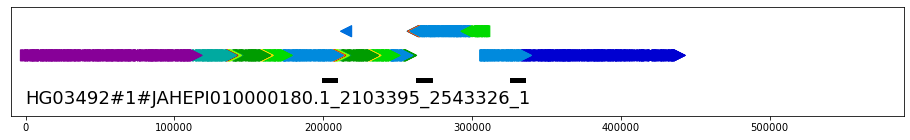

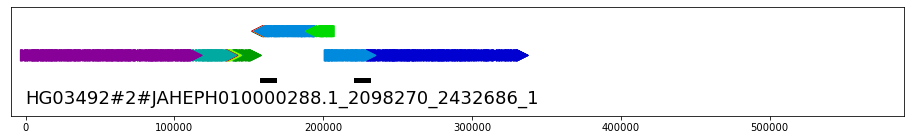

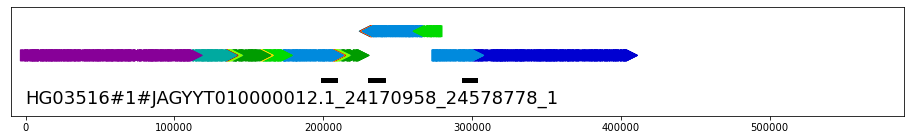

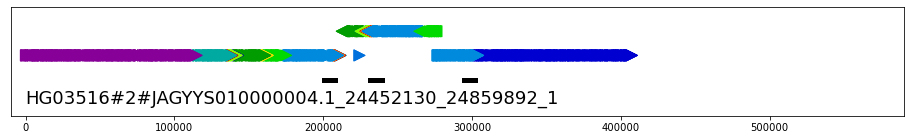

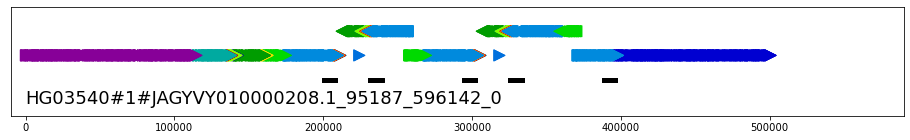

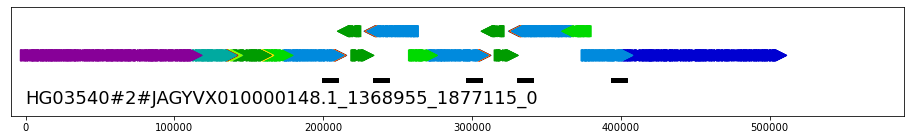

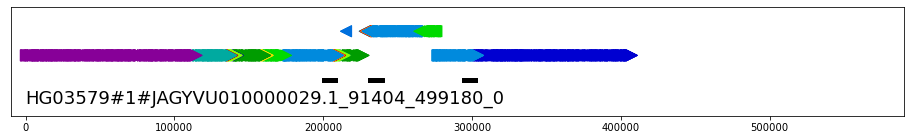

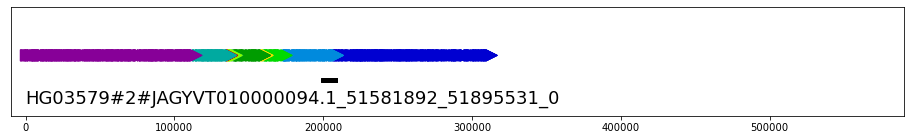

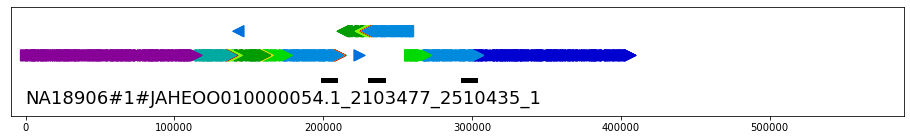

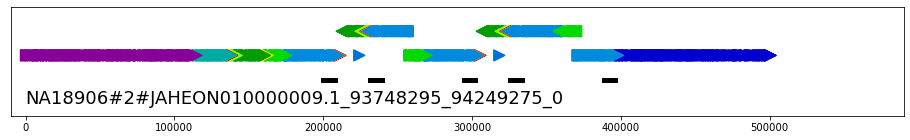

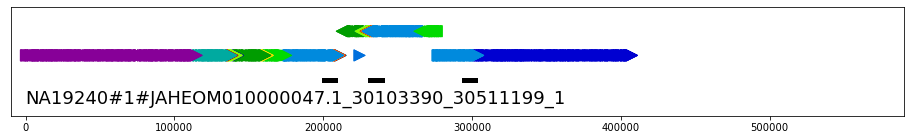

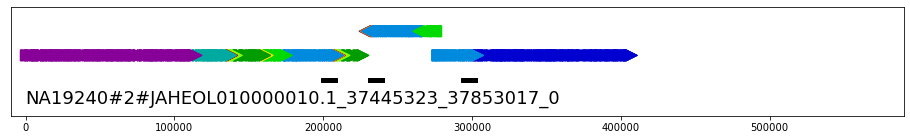

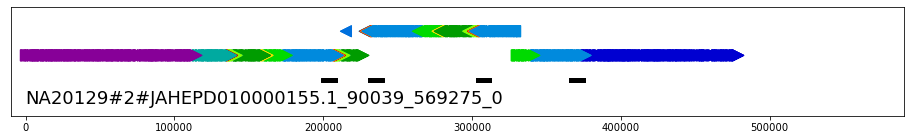

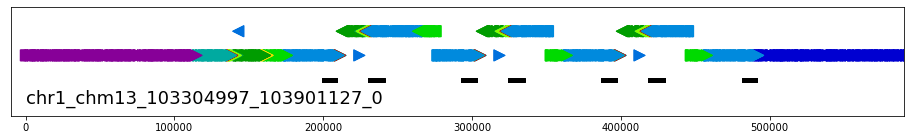

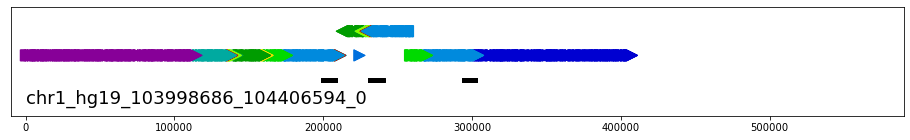

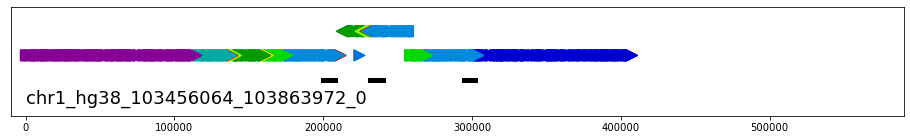

In [38]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])


pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
    matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(4)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.figure(figsize=(16,2))
    plt.scatter(x, y, marker=">", color=c, s=120)
    plt.scatter(rx, ry, marker="<", color=rc, s=120)
    
    #plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color=track0_c, s=20)
    
    track0_x = [_[0] for _ in gene_matches[sid]]
    plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color="black", s=20)
    
    #plt.axis("off")
    plt.ylim(-10,8)
    plt.yticks([])
    plt.xlim(-10000,590000)
    plt.text(0, -8, ctg, fontsize=18)

In [39]:
from matplotlib.colors import to_hex as to_hex

In [40]:
def get_graph3(seq_list, w=48, k=56, r=4, min_span=28):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():

        path.sort()
        v = path[0]

        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            #penwidth =  0.25 + 0.01 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = 0, color="yellow" )
            G.add_edge(w, v, penwidth = 0, color="yellow" )
            #G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
    links = new_sdb.get_smp_adj_list(0)
    #principal_bundles = new_sdb.get_principal_bundles(0, 8);
    principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
    
    lpb = len(principal_bundles)
    color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
    #pseudo-randomize the colors
    idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
    print(idx)
    color_theme = color_theme0[idx]

    node_to_path_id = {}

    for bundle_id, _, bundle in principal_bundles:
        for v in bundle:
            node_to_path_id[tuple(v[:2])] = bundle_id

    
    for sid, path in sid_to_path.items():
        
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            
            if v in node_to_path_id:
                path_id = node_to_path_id[v]
                G.add_node(v, fillcolor=to_hex(color_theme[path_id]), color="white" , style="filled", path_id = path_id)
            else:
                G.add_node(v, color="white", path_id = "-1" )
    return G



In [41]:
w = shmmrspec["w"]
k = shmmrspec["k"]
r = shmmrspec["r"]
min_span = shmmrspec["min_span"]
name="AMY1A_region_segment"
print(w,k,r,min_span)
G = get_graph3(seq_list, w=w, k=k, r=r, min_span=min_span)

48 56 4 28
[ 0  3  6  9 12 15 18 21 24 27  2  5  8 11 14 17 20 23 26  1  4  7 10 13
 16 19 22 25]
